# dfencoder Demo: Census Dataset

In [1]:
import torch

In [2]:
#these are our libraries
from dfencoder import AutoEncoder
import numpy as np
import pandas as pd

#and, for pretty visualiations...
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%config InlineBackend.figure_format = 'retina'

# About the Data

In [3]:
#load and look at the data
df = pd.read_csv('https://github.com/AlliedToasters/dfencoder/raw/master/adult.csv')

#this dataset contains nulls and ' ?'. Let's make these all nulls.
df = df.applymap(lambda x: np.nan if x==' ?' else x)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# Validation on Hold-Out Set

In [4]:
train = df.sample(frac=.8, random_state=42)
test = df.loc[~df.index.isin(train.index)]

X_train = train
X_val = test

# Building A Model

In [5]:
model = AutoEncoder(
    encoder_layers = [512, 512, 512], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.01,
    lr_decay=.99,
    batch_size=512,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=3 #Define cutoff for minority categories, default 10
)

# Fitting the Model

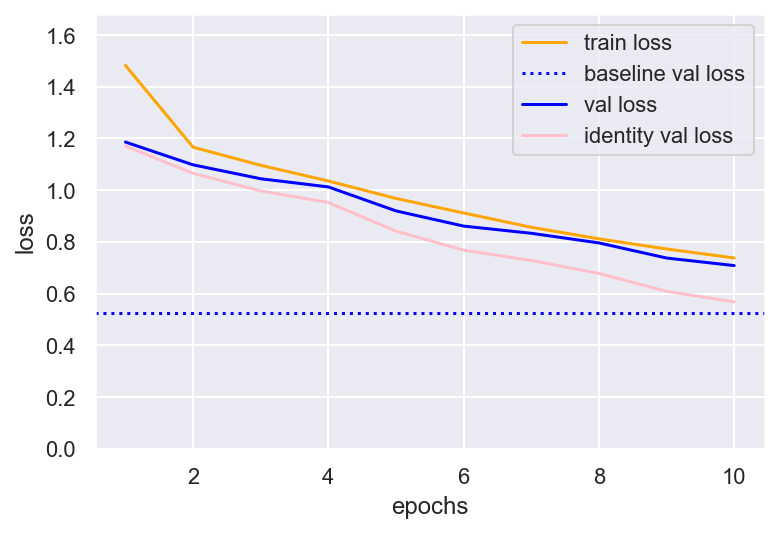

In [6]:
model.fit(X_train, epochs=10, val=X_val)

# Model Evaluation

# "Deep Stack" Features

In [7]:
z = model.get_deep_stack_features(X_val)
print(z.shape)
print(z[0, :])

torch.Size([6512, 1536])
tensor([0.8113, 0.1103, 0.4432,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')


# BUT WAIT!

In [8]:
X_train.salary.unique()

array(['<50k', '>=50k'], dtype=object)

In [9]:
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score
import numpy as np
import torch
import tqdm

class ClassifierModel(torch.nn.Module):
    """A simple classifier neural network."""
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(1536, 512)
        self.dropout = torch.nn.Dropout(.5)
        self.dense = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel().to("cuda:0")

optim = torch.optim.Adam(
    classifier.parameters(),
    weight_decay=.01
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .99)

loss = torch.nn.modules.loss.BCELoss()

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt

def do_evaluation(classifier, z, target, loss):
    with torch.no_grad():
        pred = classifier(z)
        probs = pred.cpu().numpy().reshape(-1)
        predictions = np.where(probs > .5, 1, 0)

        accuracy = np.where(target==predictions, 1, 0).sum()/len(predictions)
        f1 = f1_score(target, predictions)

        target_ = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
        loss_ = loss(pred, target_)
        return loss_.item(), accuracy, f1

  
batch_size = 256
n_updates = (len(X_train)//batch_size) + 1

n_epochs = 10

#To extract features, we'll set the target column on the input
#equal to the majority class: <50k

X_train2 = X_train.copy()
X_train2['salary'] = ['<50k' for _ in X_train2['salary']]
z_train = model.get_deep_stack_features(X_train2)

Y_train = np.where(X_train['salary'].values == '<50k', 0, 1)

X_test2 = X_val.copy()
X_test2['salary'] = ['<50k' for _ in X_test2['salary']]
z_test = model.get_deep_stack_features(X_test2)
Y_test = np.where(X_val['salary'].values == '<50k', 0, 1)

for j in range(n_epochs):
    if j % 100 == 0:
      print(f'{j} epochs complete...')
    for i in range(n_updates):
        step = i
        start = int((step) * batch_size)
        stop = int((step+1) * batch_size)
        in_ = z_train[start:stop]
        target = Y_train[start:stop]
        do_step(classifier, optim, in_, target, loss)
    decay.step()
    bce_loss, accuracy, f1 = do_evaluation(classifier, z_test, Y_test, loss)
print('\nFinal results: ')
print('validation loss: ', round(bce_loss, 4))
print('validation accuracy: ', round(accuracy, 3))
print('validation f1 score: ', round(f1, 3))

0 epochs complete...

Final results: 
validation loss:  0.3885
validation accuracy:  0.816
validation f1 score:  0.593


# How We Handled the Target

# Anomaly Detection

In [10]:
scores = model.get_anomaly_score(X_val)
X_val['anomaly_score'] = scores
X_val.sort_values('anomaly_score', ascending=False).head()

C:\Users\varun\AppData\Local\Temp\ipykernel_13616\124287795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['anomaly_score'] = scores


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,anomaly_score
21004,32,Private,112137,Preschool,1.0,Married-civ-spouse,Machine-op-inspct,Wife,Asian-Pac-Islander,Female,4508,0,40,Cambodia,<50k,2.998925
16673,75,Private,71898,Preschool,1.0,Never-married,Priv-house-serv,Not-in-family,Asian-Pac-Islander,Female,0,0,48,Philippines,<50k,2.748842
18431,39,NaN,362685,Preschool,1.0,Widowed,NaN,Not-in-family,White,Female,0,0,20,El-Salvador,<50k,2.715962
3163,23,Private,240049,Preschool,1.0,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Female,0,0,40,Laos,<50k,2.635139
32444,59,Private,157305,Preschool,1.0,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,Dominican-Republic,<50k,2.298588


# Imputation

In [11]:
#imputed_values = model.df_predict(X_val.drop(columns='anomaly_score'))
#imputed_values['anomaly_score'] = scores
#imputed_values.sort_values('anomaly_score', ascending=False).head()

In [12]:
from scipy.spatial.distance import cosine

def compare_category(model, feature, cat):
    """Ranks categories based on distance from category in question."""
    feature = model.categorical_fts[feature]
    cats = feature['cats'] + ['_other']
    scores = []
    this_cat = cats.index(cat)
    emb = feature['embedding']
    
    ft_embedding = emb.weight.data.cpu().numpy()[this_cat, :]
    
    for i, cat_ in enumerate(cats):
        vec = emb.weight.data.cpu().numpy()[i, :]
        similarity = cosine(ft_embedding, vec)
        scores.append(similarity)
        
    scrnm = f'distance from {cat}'
    result = pd.DataFrame(columns=['category', scrnm])
    result['category'] = cats
    result[scrnm] = scores
    
    print(result.sort_values(scrnm))
    
compare_category(model, 'occupation', ' Farming-fishing')

              category  distance from  Farming-fishing
9      Farming-fishing                        0.000000
2      Exec-managerial                        0.355341
1         Craft-repair                        0.525239
8    Handlers-cleaners                        0.591923
14              _other                        0.626627
11     Protective-serv                        0.628219
12     Priv-house-serv                        0.778396
4                Sales                        0.848896
10        Tech-support                        0.919160
5        Other-service                        1.200939
6    Machine-op-inspct                        1.288903
0       Prof-specialty                        1.324627
13        Armed-Forces                        1.334405
3         Adm-clerical                        1.389032
7     Transport-moving                        1.593981
